<a href="https://colab.research.google.com/github/mashyko/Image-Classifier/blob/master/transfer_learning_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


Transfer Learning and finetuning code for Pytorch
==========================
 Adopted from PyTorch Tutorials written by Sasank Chilamkurthy # License: BSD
 <https://chsasank.github.io>



In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

This dataset is a very small subset of imagenet. Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.


In [0]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip
!rm hymenoptera_data.zip

--2020-04-22 00:53:56--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.35.99.25, 13.35.99.32, 13.35.99.128, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.99.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  --.-KB/s    in 0.1s    

2020-04-22 00:53:56 (342 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




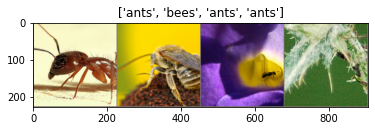

In [0]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions

Generic function to display predictions for a few images



In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Transfer Training ResNet 18
----------------------

Load a pretrained model and train weights for ants and bees datasets




In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.



In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5690 Acc: 0.7090
val Loss: 0.2280 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.5777 Acc: 0.7705
val Loss: 1.3643 Acc: 0.6536

Epoch 2/24
----------
train Loss: 0.8214 Acc: 0.7049
val Loss: 0.2839 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.5665 Acc: 0.7787
val Loss: 0.2856 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.5013 Acc: 0.7746
val Loss: 0.3781 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.5801 Acc: 0.7746
val Loss: 0.2445 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3467 Acc: 0.8566
val Loss: 0.2074 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3406 Acc: 0.8566
val Loss: 0.1860 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3654 Acc: 0.8279
val Loss: 0.2189 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3185 Acc: 0.8484
val Loss: 0.1939 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3807 Acc: 0.8156
val Loss: 0.2430 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3482 Acc: 0.8566
val Loss: 0.2265 Acc: 0.9150

Epoch 12/24
----------
t

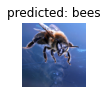

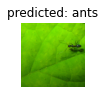

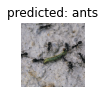

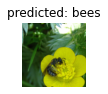

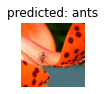

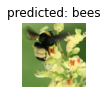

In [0]:
visualize_model(model_ft)


Finetuning ResNet 18
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.



In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate




In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6848 Acc: 0.6516
val Loss: 0.2792 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.5356 Acc: 0.7377
val Loss: 0.2948 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4214 Acc: 0.8238
val Loss: 0.2010 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4064 Acc: 0.8156
val Loss: 0.2099 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4878 Acc: 0.7746
val Loss: 0.1968 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4619 Acc: 0.7951
val Loss: 0.2121 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4543 Acc: 0.8156
val Loss: 0.1722 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3621 Acc: 0.8279
val Loss: 0.1566 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2783 Acc: 0.8811
val Loss: 0.1718 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3312 Acc: 0.8484
val Loss: 0.1575 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3216 Acc: 0.8607
val Loss: 0.1659 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.2751 Acc: 0.8689
val Loss: 0.1598 Acc: 0.9477

Epoch 12/24
----------
t

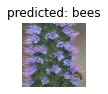

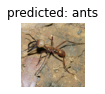

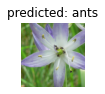

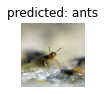

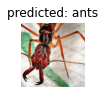

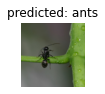

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Good job!